<a href="https://colab.research.google.com/github/woanderer/miscellaneous/blob/master/leela_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import torch
import numpy as np

import time

import matplotlib.pyplot as plt

In [22]:
def generate_dfs_np(low, high, dim):
  start = time.time()

  on_taken = np.random.randint(low, high, size=dim)
  off_taken = np.random.randint(low, high, size=dim)
  taken_trials = on_taken + off_taken
  on_not_taken = np.random.randint(low, high, size=dim)
  off_not_taken = np.random.randint(low, high, size=dim)
  not_taken_trials = on_not_taken + off_not_taken

  p_on_taken = on_taken / taken_trials
  p_off_taken = off_taken / taken_trials

  p_on_not_taken = on_not_taken / not_taken_trials
  p_off_not_taken = off_taken / taken_trials

  return (on_taken, taken_trials,
          off_taken, on_not_taken, 
          not_taken_trials, off_not_taken, 
          p_on_taken, p_off_taken, 
          p_on_not_taken, p_off_not_taken)

In [23]:
def generate_dfs_cuda(low, high, dim):
  start = time.time()

  on_taken = torch.randint(low, high, dim, dtype=torch.float, device=torch.device('cuda'))
  off_taken = torch.randint(low, high, dim, dtype=torch.float, device=torch.device('cuda'))
  taken_trials = on_taken + off_taken
  on_not_taken = torch.randint(low, high, dim, dtype=torch.float, device=torch.device('cuda'))
  off_not_taken = torch.randint(low, high, dim, dtype=torch.float, device=torch.device('cuda'))
  not_taken_trials = on_not_taken + off_not_taken

  p_on_taken = on_taken / taken_trials
  p_off_taken = off_taken / taken_trials

  p_on_not_taken = on_not_taken / not_taken_trials
  p_off_not_taken = off_taken / taken_trials

  return (on_taken, taken_trials,
          off_taken, on_not_taken, 
          not_taken_trials, off_not_taken, 
          p_on_taken, p_off_taken, 
          p_on_not_taken, p_off_not_taken)


In [24]:
def generate_stats(function, low, high, dim):
  start = time.time()
  if function is np:
    (on_taken, taken_trials,
     off_taken, on_not_taken,
     not_taken_trials, off_not_taken,
     p_on_taken, p_off_taken,
     p_on_not_taken, p_off_not_taken) = generate_dfs_np(low, high, dim)

    p_hat_on = function.divide((on_taken + on_not_taken),
                        taken_trials + not_taken_trials)
    p_hat_off = function.divide((off_taken + off_not_taken),
                          taken_trials + not_taken_trials)
    
    test_statistic_on = function.divide((p_on_taken - p_on_not_taken),
                                  function.sqrt(p_hat_on * (1 - p_hat_on) * (
                                      1. / taken_trials + 1. / not_taken_trials)))
    test_statistic_off = function.divide((p_off_taken - p_off_not_taken),
                                  function.sqrt(p_hat_off * (1 - p_hat_off) * (
                                      1. / taken_trials + 1. / not_taken_trials)))     

  elif function is torch:
    (on_taken, taken_trials,
     off_taken, on_not_taken,
     not_taken_trials, off_not_taken,
     p_on_taken, p_off_taken,
     p_on_not_taken, p_off_not_taken) = generate_dfs_cuda(low, high, dim)
  
    p_hat_on = torch.div((on_taken + on_not_taken),
                        taken_trials + not_taken_trials)
    p_hat_off = torch.div((off_taken + off_not_taken),
                          taken_trials + not_taken_trials)
    
    test_statistic_on = torch.div((p_on_taken - p_on_not_taken),
                                  torch.sqrt(p_hat_on * (1 - p_hat_on) * (
                                      1. / taken_trials + 1. / not_taken_trials)))
    test_statistic_off = torch.div((p_off_taken - p_off_not_taken),
                                  torch.sqrt(p_hat_off * (1 - p_hat_off) * (
                                      1. / taken_trials + 1. / not_taken_trials)))
  p_values_pos = -test_statistic_on
  p_values_neg = -test_statistic_off

  duration = time.time() - start
  
  return p_values_pos, p_values_neg, duration

In [25]:
start = time.time()

(on_taken, taken_trials, 
 off_taken, on_not_taken, 
 not_taken_trials, off_not_taken, 
 p_on_taken, p_off_taken, 
 p_on_not_taken, p_off_not_taken) = generate_dfs_np(10**5, 10**6, (1,))

time.time() - start

0.0007252693176269531

In [26]:
start = time.time()

(on_taken, taken_trials,
 off_taken, on_not_taken,
 not_taken_trials, off_not_taken,
 p_on_taken, p_off_taken,
 p_on_not_taken, p_off_not_taken) = generate_dfs_cuda(10**5, 10**6, (1,))

time.time() - start

0.0008890628814697266

In [27]:
a = torch.randint(10**10, 10**11, (10000,600), dtype=torch.float, device=torch.device('cuda'))
b = torch.randint(10**10, 10**11, (10000,600), dtype=torch.float, device=torch.device('cuda'))

# comparing * to torch.mul:

start = time.time()
c = a * b
end1 = time.time() - start

start = time.time()
d = torch.mul(a, b)
end2 = time.time() - start

print(end1, end2)

## equivalent averaged over multiple trials, only thing that matters is being on GPU.

0.0008692741394042969 0.004145622253417969


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: from is out of bounds [-(2^24), 2^24]. Due to precision limitations float can support discrete uniform distribution only within this range. This warning will become an error in version 1.7 release, please fix the code in advance (Triggered internally at  /pytorch/aten/src/ATen/native/DistributionTemplates.h:90.)
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: to - 1 is out of bounds [-(2^24), 2^24]. Due to precision limitations float can support discrete uniform distribution only within this range. This warning will become an error in version 1.7 release, please fix the code in advance (Triggered internally at  /pytorch/aten/src/ATen/native/DistributionTemplates.h:90.)
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: from is out of bounds [-(2^24), 2^24]. 

In [28]:
# run it with numpy dim (1,)

start = time.time()
for i in range(10000):
  generate_stats(function=np, low=10**5, high=10**6, dim=(1,))

time.time() - start

0.7445907592773438

In [29]:
# run it with pytorch

start = time.time()
for i in range(10000):
  generate_stats(function=torch, low=10**5, high=10**6, dim=(1,))

time.time() - start

4.346864461898804

In [30]:
# run it with numpy dim (600,)

start = time.time()
for i in range(10000):
  generate_stats(function=np, low=10**5, high=10**6, dim=(600,))

time.time() - start

1.2307994365692139

In [31]:
# run it with pytorch dim (600,)

start = time.time()
for i in range(10000):
  generate_stats(function=torch, low=10**5, high=10**6, dim=(600,))

time.time() - start

4.382487058639526

In [32]:
# run it with numpy dim (10**5)

start = time.time()
for i in range(10000):
  generate_stats(function=np, low=10**5, high=10**6, dim=(10**5,))

time.time() - start

96.94124388694763

In [33]:
# run it with pytorch with dim (10**5)

start = time.time()
for i in range(10000):
  generate_stats(function=torch, low=10**5, high=10**6, dim=(10**5,))

time.time() - start

4.314376354217529

In [48]:
###---> HERE run it with numpy with dimensions accross orders (dims: 10^n) of magnitude.

stats_np = []
for i in range(7):
  start = time.time()
  for j in range(10000):
    generate_stats(function=np, low=10**5, high=10**6, dim=(10**i,))
  end = time.time() - start
  stats_np.append(end)

  print('np (cpu) time for order of magnitude: ', i, end)

np (cpu) time for order of magnitude:  0 0.7077023983001709
np (cpu) time for order of magnitude:  1 0.7185628414154053
np (cpu) time for order of magnitude:  2 0.7710311412811279
np (cpu) time for order of magnitude:  3 1.4613230228424072
np (cpu) time for order of magnitude:  4 7.979762077331543
np (cpu) time for order of magnitude:  5 94.70481324195862
np (cpu) time for order of magnitude:  6 974.6972246170044


In [50]:
# run it with torch with dimesions accross orders (dims: 10^n) of magnitude.

stats_torch = []
for i in range(7):
  start = time.time()
  for j in range(10000):
    generate_stats(function=torch, low=10**5, high=10**6, dim=(10**i,))
  end = time.time() - start
  stats_torch.append(end)

  print('torch (gpu) time for order of magnitude ' , i, end)


torch (gpu) time for order of magnitude  0 4.165910482406616
torch (gpu) time for order of magnitude  1 4.255849123001099
torch (gpu) time for order of magnitude  2 4.211747884750366
torch (gpu) time for order of magnitude  3 4.185648202896118
torch (gpu) time for order of magnitude  4 4.233033895492554
torch (gpu) time for order of magnitude  5 4.256673097610474
torch (gpu) time for order of magnitude  6 8.912560224533081


In [51]:
stats_np

[0.7077023983001709,
 0.7185628414154053,
 0.7710311412811279,
 1.4613230228424072,
 7.979762077331543,
 94.70481324195862,
 974.6972246170044]

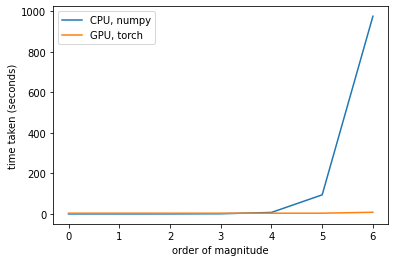

In [62]:
x_axis = np.arange(0, 7, 1)

plt.xlabel('order of magnitude')
plt.ylabel('time taken (seconds)')

plt.plot(x_axis, stats_np)
plt.plot(x_axis, stats_torch)

plt.legend(["CPU, numpy", "GPU, torch"])

In [56]:
# run it with numpy with dimensions accross orders (dims: 10^(n) x 10^(n)) of magnitude.

stats_np_2 = []
for i in range(0,4):
  start = time.time()
  for j in range(10000):
    generate_stats(function=np, low=10**5, high=10**6, dim=(10**i,10**i))
  end = time.time() - start
  stats_np_2.append(end)

  print('np (cpu) time for order of magnitude: ', i*i, end)

np (cpu) time for order of magnitude:  0 0.7765994071960449
np (cpu) time for order of magnitude:  1 0.8302211761474609
np (cpu) time for order of magnitude:  4 7.903716802597046
np (cpu) time for order of magnitude:  9 984.3678810596466


In [57]:
# run it with torch with dimensions accross orders (10^(n) x 10^(n)) of magnitude.

stats_torch_2 = []
for i in range(0,4):
  start = time.time()
  for j in range(10000):
    generate_stats(function=torch, low=10**5, high=10**6, dim=(10**i,10**i))
  end = time.time() - start
  stats_torch_2.append(end)

  print('torch (gpu) time for order of magnitude: ', i*i, end)

torch (gpu) time for order of magnitude:  0 4.232057809829712
torch (gpu) time for order of magnitude:  1 4.239463567733765
torch (gpu) time for order of magnitude:  4 4.331871032714844
torch (gpu) time for order of magnitude:  9 8.925877332687378


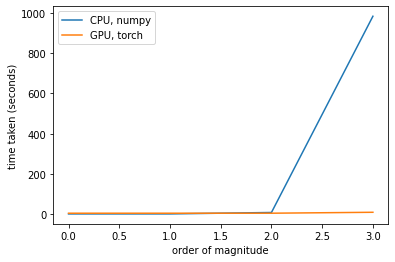

In [60]:
x_axis = np.arange(0, 4, 1)

plt.xlabel('order of magnitude')
plt.ylabel('time taken (seconds)')

plt.plot(x_axis, stats_np_2)
plt.plot(x_axis, stats_torch_2)

plt.legend(["CPU, numpy", "GPU, torch"])